# 【AAPlot 多图版】
## 用于对Spike2输出的txt文件绘制时间序列图

1. 输入数据为Spike2直接输出的Spreadsheet类文件，格式为.csv或.txt.
2. 文件内容应为三列：
    - 第一列为时间
    - 第二列为数据点
    - 第三列为药物注射时间打标，数据中改行显示为1 ~~多图时根据打标位置做align~~
3. 在`PLOT` 运行环境下工作
    
    PLOT环境：

    - Python3.12.7
    - pandas
    - numpy
    - matplotlib
    - seaborn
    - ipykernel

*注意:*

*! 运行前确保安装了最新版 `Anaconda`，并添加到系统PATH（可参考网络上配置方法）*

*! 运行前确保配置好了`PLOT`环境: `conda env create -n PLOT python=3.12.7 pandas numpy matplotlib seaborn ipykernel` (ARM64处理器可以使用Python3.13.3，注意在命令最后添加conda-forge)*

*VScode 下运行环境：直接在Kernel中选择即可*

*命令行下运行环境：`conda activate PLOT`*

## Step1：数据输入

In [88]:
# 导入必要库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [89]:
# 设定目录
folder_path = '/Users/ruyicai/Desktop/2-AG/THC' # for mac and linux
# folder_path = r'D:\Science\Experiment data\eCB sensors\Selective sensor\FiberPhotometry\Drug intake\NAcSh_All_data_in_1_folder\01 Summary\2-AG\THC'  # for windows，注意那个r

# 获取文件夹中所有txt文件的路径
txt_files = glob.glob(os.path.join(folder_path, '*.txt'))
# 对所有文件进行排序
txt_files.sort()
# 创建一个空的列表来存储数据
all_data = []
# 读取所有txt文件,并将数据存储到结构化数据中
for file in txt_files:
    df = pd.read_csv(file, sep=',')
    all_data.append(df)
# 重算每个dataframe中的时间为小时
for i in range(len(all_data)):
    all_data[i].iloc[:, 0] = all_data[i].iloc[:, 0] - all_data[i].iloc[:, 0][all_data[i].iloc[:, 2] == 1].values[0]
    # all_data[i].iloc[:, 0] = all_data[i].iloc[:, 0] / 3600
# 计算每个dataframe的时间间隔
dt = all_data[0].iloc[1, 0] - all_data[0].iloc[0, 0]  # 假设所有文件的时间间隔相同
# 设定一个空的dataframe来存储对齐后的数据
all_data_aligned = pd.DataFrame()
# 计算每个dataframe中时间为0的位置
time_0_indices = []
for i in range(len(all_data)):
    time_0_index = all_data[i].iloc[:, 0][all_data[i].iloc[:, 2] == 1].index[0]
    time_0_indices.append(time_0_index)

# 根据第一列的0对齐第二列数据，所有数据保持原有长度，不作截断，空值用NAN
max_pre_len = max(time_0_indices)  # 获取最长的"time=0前"的数据长度
max_post_len = max([len(df) - idx for df, idx in zip(all_data, time_0_indices)])  # 获取最长的"time=0后"的数据长度

for i, df in enumerate(all_data):
    # 提取信号列（假设第二列是信号数据）
    signal = df.iloc[:, 1]  # 修改1为实际的信号列索引
    
    # 对齐前段数据（time=0之前）
    pre_signal = signal[:time_0_indices[i]]
    padded_pre = [np.nan] * (max_pre_len - len(pre_signal)) + pre_signal.tolist()
    
    # 对齐后段数据（time=0之后）
    post_signal = signal[time_0_indices[i]:]
    padded_post = post_signal.tolist() + [np.nan] * (max_post_len - len(post_signal))
    
    # 合并
    aligned_signal = padded_pre + padded_post
    
    # 添加到结果DataFrame
    all_data_aligned[f'signal_{i}'] = aligned_signal

# 重新计算时间轴（小时单位）
pre_time = np.linspace(-max_pre_len * dt/3600, 0, max_pre_len, endpoint=False)  # 0之前：从小负→0
post_time = np.linspace(0, max_post_len * dt/3600, max_post_len, endpoint=False)[1:]  # 0之后：排除重复的0点
time_axis = np.concatenate([pre_time, [0], post_time])  # 精确包含0点

# # 重新计算时间轴（分钟单位）
# pre_time = np.linspace(-max_pre_len * dt/60, 0, max_pre_len, endpoint=False)  # 0之前：从小负→0
# post_time = np.linspace(0, max_post_len * dt/60, max_post_len, endpoint=False)[1:]  # 0之后：排除重复的0点
# time_axis = np.concatenate([pre_time, [0], post_time])  # 精确包含0点

# 创建最终DataFrame，第一列时间，最后一列均值
final_df = pd.DataFrame(
    data=time_axis.reshape(-1, 1),  # 时间数据作为第一列
    columns=['Time(h)']  # 明确命名时间列
)
# 加入信号数据
for i, col in enumerate(all_data_aligned.columns):
    final_df[f'signal_{i}'] = all_data_aligned[col]

# 计算并添加均值列
final_df['Mean'] = final_df.iloc[:, 1:-1].mean(axis=1, skipna=True)  # 从第1列到倒数第1列计算均值
# 计算并添加标准差列
final_df['Std'] = final_df.iloc[:, 1:-1].std(axis=1, skipna=True)  # 从第1列到倒数第1列计算标准差
# 计算并添加标准误列
final_df['StdErr'] = final_df.iloc[:, 1:-1].std(axis=1, skipna=True) / np.sqrt(len(all_data_aligned.columns) - 1)  # 从第1列到倒数第1列计算标准误

# # 输出为csv文件
# output_file = os.path.join(folder_path, 'aligned_data.csv')
# final_df.to_csv(output_file, index=False)



## Step2：作图

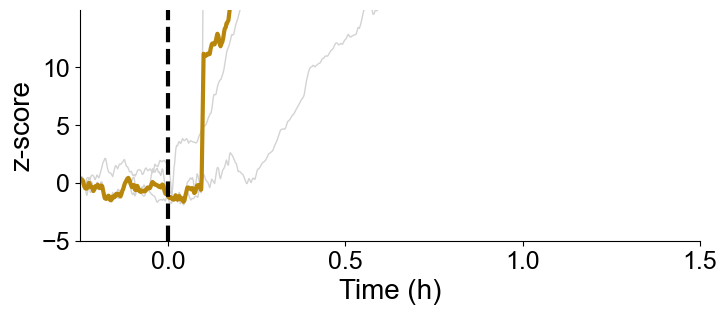

In [90]:
# data数据第一列第二行开始为时，第二列第二行开始为数据，第三列为打标

plt.figure(figsize=(8, 3)) # 图像大小

# 把所有final_df中标题名为signal_的列提取出来
signal_columns = [col for col in final_df.columns if 'signal_' in col]

# 对所有signal_列进行作图
for col in signal_columns:
    plt.plot(final_df.iloc[:, 0], final_df[col], label=col, color='lightgrey',linewidth=1) # 绘制数据曲线
# plt.plot(final_df.iloc[:, 0], final_df['Mean'], label='Mean', color='steelblue',linewidth=3) # 绘制均值曲线
# # plt.fill_between(final_df.iloc[:, 0], final_df['Mean'] - final_df['StdErr'], final_df['Mean'] + final_df['StdErr'], color='royalblue', alpha=0.2) # 绘制均值的标准误带

plt.plot(final_df.iloc[:, 0], final_df['Mean'], label='Mean', color='darkgoldenrod',linewidth=3) # 绘制均值曲线
# plt.fill_between(final_df.iloc[:, 0], final_df['Mean'] - final_df['StdErr'], final_df['Mean'] + final_df['StdErr'], color='darkgoldenrod', alpha=0.2) # 绘制均值的标准误带


#====格式处理====#
# plt.title('Time Series Plot',fontsize=24) # 设置标题
# plt.legend(fontsize=16) # 添加图例
plt.rcParams['font.sans-serif'] = ['Arial']  # 设置字体为Arial

plt.xlabel('Time (h)', fontsize=20) # 设置x轴标签
plt.ylabel('z-score', fontsize=20) # 设置y轴标签

# plt.xticks(np.arange(-2,8.1, 2),fontsize=18) # 设置x轴刻度 for THC i.p.,8h
# plt.yticks(np.arange(-20,81, 20),fontsize=18) # 设置y轴刻度 for THC i.p., -10 to 80
plt.xticks(np.arange(-0.5,2.1, 0.5),fontsize=18) # 设置x轴刻度 
plt.yticks(np.arange(-5,15, 5),fontsize=18) # 设置y轴刻度 

# plt.xlim(-0.5, 8)  # 设置x轴范围 for THC i.p.,8h
# plt.ylim(-5, 80)  # 设置y轴范围 for THC i.p., -10 to 80
plt.xlim(-0.25, 1.5)  # 设置x轴范围
plt.ylim(-5, 15)  # 设置y轴范围

plt.axvline(0, color='black', linestyle='--', linewidth=3)  # 添加x=0的虚线
# plt.axhline(0, color='black', linestyle='--', linewidth=1)  # 添加y=0的虚线

plt.gcf().patch.set_alpha(0.0)  # 设置图像背景透明
plt.gca().patch.set_alpha(0.0)  # 设置数据区域背景透明
sns.despine() # 删除图像边框

# 保存为svg格式
output_fig = os.path.join(folder_path, 'plot.svg')
plt.savefig(output_fig, format='svg', bbox_inches='tight')


# Step3: 分析peak zscore和AUC

In [ ]:
# 计算每列数据打标之后300秒后至打标后1小时300秒内的最大值，最小值以及曲线下面积
# 对每列数据进行进行平滑化，使用Savitzky-Golay滤波器，窗口设为2001，阶数设为2
from scipy.signal import savgol_filter
def smooth_data(df, window_length=2001, polyorder=2):
    # 对每列数据进行平滑化
    smoothed_df = df.copy()
    for col in df.columns[1:-3]:  # 排除时间列和统计列
        smoothed_df[col] = savgol_filter(df[col], window_length, polyorder, mode='nearest')
    return smoothed_df
smoothed_df = smooth_data(final_df)
def calculate_metrics(df, start_time=300, end_time=2100):
    # 计算时间范围内的最大值、最小值和曲线下面积
    metrics = {}
    for col in df.columns[1:-3]:  # 排除时间列和统计列
        # 筛选时间范围内的数据
        mask = (df['Time(h)'] >= start_time / 3600) & (df['Time(h)'] <= end_time / 3600)
        filtered_data = df.loc[mask, col]
        # 计算最大值、最小值和曲线下面积
        # 注意：这里假设时间间隔为1秒计算，转换为小时单位
        if not filtered_data.empty:
            metrics[col] = {
                'max': filtered_data.max(),
                'min': filtered_data.min(),
                'area': np.trapezoid(filtered_data, dx=1/3600)  # 使用梯形积分计算曲线下面积
            }
        else:
            metrics[col] = {'max': np.nan, 'min': np.nan, 'area': np.nan}
    
    return pd.DataFrame(metrics).T
# 计算指标
metrics_df = calculate_metrics(smoothed_df)
# 输出指标到csv文件
output_metrics = os.path.join(folder_path, 'metrics.csv')
metrics_df.to_csv(output_metrics, index=True)
# 输出指标到控制台
print(metrics_df)

# # 在同一张图中plot第一个数据的平滑化前后的数据
# plt.figure(figsize=(8, 3))  # 图像大小
# plt.plot(smoothed_df.iloc[:, 0], final_df['signal_5'], label='Smoothed signal_0', color='darkgoldenrod', linewidth=3)  # 绘制平滑化后的数据
# plt.plot(final_df.iloc[:, 0], smoothed_df['signal_5'], label='Original signal_0', color='black', linewidth=1)  # 绘制原始数据
# plt.xlabel('Time (h)', fontsize=20)  # 设置x轴标签
# plt.ylabel('z-score', fontsize=20)  # 设置y轴标签
# plt.xticks(np.arange(-0.5, 2.1, 0.5), fontsize=18)  # 设置x轴刻度
# plt.yticks(np.arange(-5, 15, 5), fontsize=18)  # 设置y轴刻度
# plt.xlim(-0.5, 2)  # 设置x轴范围
# plt.ylim(-5, 15)  # 设置y轴范围
# plt.axvline(0, color='black', linestyle='--', linewidth=3)  # 添加x=0的虚线
# plt.gcf().patch.set_alpha(0.0)  # 设置图像背景透明
# plt.gca().patch.set_alpha(0.0)  # 设置数据区域背景透明
# sns.despine()  # 删除图像边框
# # 保存平滑化前后的图像为svg格式
# # output_smooth_fig = os.path.join(folder_path, 'smooth_plot.svg')
# # plt.savefig(output_smooth_fig, format='svg', bbox_inches='tight')




                max       min        area
signal_0  15.384565 -0.768418   31.127888
signal_1  50.595798  0.792304  183.737642
signal_2  46.258061  3.895760  124.106286
